In [10]:
import sys
sys.path.append('/Users/elenaorlova/Library/Python/3.7/lib/python/site-packages')
import numpy as np 
#import t3nsor as t3

In [11]:
import ttpy

In [13]:
import tt
from als import ttSparseALS

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [815]:
import pandas as pd

df = pd.read_csv('/Users/elenaorlova/Downloads/GlobalLandTemperatures_GlobalTemperatures.csv')
df.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [163]:
val_original = df[1200:2200]['LandAverageTemperature']

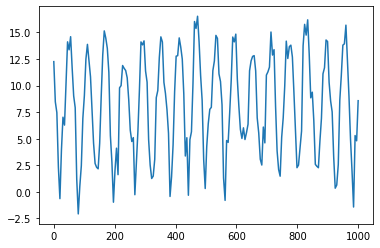

In [164]:
plt.plot(x, val_original) 

In [9]:
from scipy.io import wavfile

In [10]:
samplerate, data = wavfile.read('/Users/elenaorlova/Downloads/cmu_us_slt_arctic/wav/arctic_a0001.wav')
times = np.arange(len(data))/float(samplerate)

Text(0, 0.5, 'amplitude')

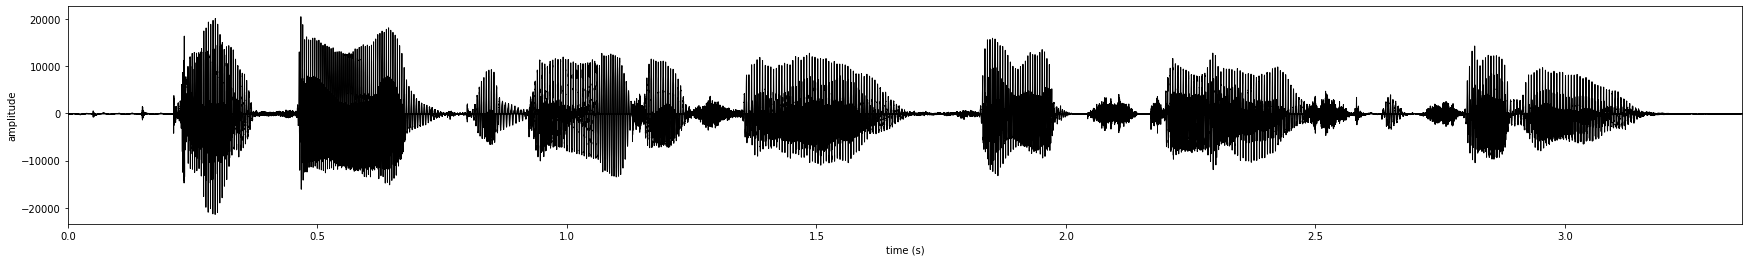

In [12]:
plt.figure(figsize=(30, 4))
plt.fill_between(times, data, color='k') 
plt.xlim(times[0], times[-1])
plt.xlabel('time (s)')
plt.ylabel('amplitude')

In [13]:
data.shape

(53680,)

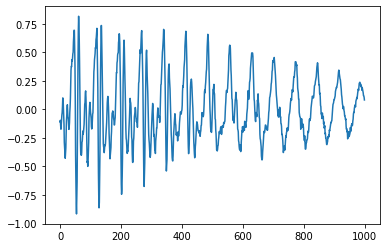

In [18]:
plt.plot(data[4800:5800] / np.max(data))

In [19]:
val_original = data[4800:5800] / np.max(data)

In [115]:
L = 1000
k1 = 2000
k2 = 30
k3 = 2e7

In [116]:
def h(n):
#     return 1.2 * (1 - 2 * k2 * np.cos(np.pi*n/k1) + 2*n*np.sin(np.pi*(n**1.5)/k1) - n)
#     return n ** 3 / L**2 + 2 * (n ** 2) / L * (np.cos(n*np.pi/k1)) + 3 * n * np.sin(n*np.pi/k2) - n**2/L
    return (n**2/L + 2*n*np.sin(np.pi*n/k1) + n*np.cos(np.pi*n/k2) - n + 4*np.round(200*np.cos(2* n**3/k3))) / L
# def h(n):
#     return np.sin(n ** 2)

In [117]:
val_original = []
for i in range(L):
    val_original.append(h(i))
val_original = np.array(val_original)

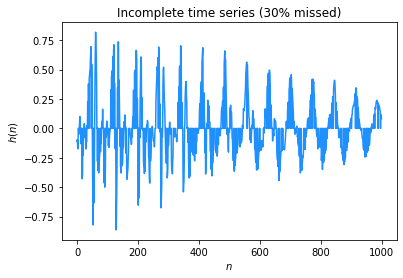

In [24]:
plt.title('Incomplete time series (30% missed)')
plt.ylabel('$h(n)$')
plt.xlabel('$n$')
a = np.multiply(val_original, mask)
# a[:30] = np.zeros(30)     
# a[-60:] = np.zeros(60)  
plt.plot(a, color='dodgerblue')
# plt.legend()
# plt.savefig('orig_speech_30mis.pdf')

In [118]:
# random mask matrix with K% zeros
def rand_bin_array(K, N):
    arr = np.zeros(N)
    arr[:K]  = 1
    np.random.shuffle(arr)
    return arr

In [186]:
K = int(0.6 * len(val_original))
mask = rand_bin_array(K, len(val_original))
# mask

In [187]:
val = np.multiply((np.ones(len(val)) - mask), np.random.randn(len(val))) + np.multiply(mask, val)
# val = np.multiply((np.ones(len(val)) - mask), res_data) + np.multiply(mask, val_original) # second stage

In [28]:
T = 6
L = 13
val = np.linspace(0, 12, 13)
val

In [69]:
index_list = np.arange(L)

In [70]:
# create Hankel matrix from val with a sliding window
hankel_matrix = []
hankel_mask = []
hankel_index = []
hankel_original = []
for i in range(0, len(val) - T + 1):
#     print(i, i+T)
    hankel_matrix.append(val[i:i+T])
    hankel_mask.append(mask[i:i+T])
    hankel_index.append(index_list[i:i+T])
    hankel_original.append(val_original[i:i+T])

In [71]:
hankel_mask = np.array(hankel_mask)
hankel_original = np.array(hankel_original)
# hankel_mask

In [72]:
hankel_matrix = np.array(hankel_matrix)
print(hankel_matrix.shape)
# hankel_matrix

(95, 6)


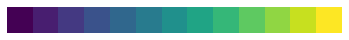

In [135]:
plt.imshow(val.reshape(1, 13))
plt.axis('off');
plt.savefig('array.pdf')

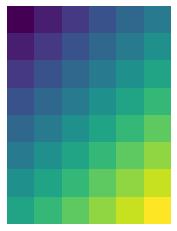

In [136]:
plt.imshow(hankel_matrix)
plt.axis('off');
plt.savefig('hankel.pdf')

In [73]:
# create a duplication matrix and return S_H1, H_matrix, S_H2
P = 1
T1 = 2
T2 = 2
def H_e_func(P, T1, T2, H_matrix):
    I1, I2 = H_matrix.shape
    if I1 % P != 0: 
        new_I1 = (I1 // P) * P + P * int(I1 % P != 0)
        H_matrix = np.concatenate((H_matrix, np.zeros((new_I1-I1, I2))), axis=0)
        I1 = new_I1
    if I2 % P != 0: 
        new_I2 = (I2 // P) * P + P * int(I2 % P != 0)
        H_matrix = np.concatenate((H_matrix, np.zeros((I1, new_I2-I2))), axis=1)
        I2 = new_I2
    
    S_H1 = np.zeros((int((P*T1*(I1/P - T1 + 1))), int(I1)))
#     print(S_H1.shape)
    S_H2 = np.zeros((int((P*T2*(I2/P - T2 + 1))), int(I2)))
    
    x = int(I1/P - T1 + 1) # number of I_p blocks
    for i in range(0, x):
        for j in range(0, min(P*T1, P*T2)):
            S_H1[P*T1*i+j, P*i + j] = 1
 
    
    x = int(I2/P - T2 + 1)
    for i in range(0, x):
        for j in range(0, min(P*T1, P*T2)):
            S_H2[P*T2*i+j, P*i + j] = 1
     
    return S_H1, H_matrix, S_H2
    

In [74]:
S_H1, H, S_H2 = H_e_func(P, T1, T2, hankel_matrix)

In [75]:
hankelized_matrix_original = S_H1 @ H @ S_H2.T

In [76]:
H_e = S_H1 @ H @ S_H2.T 

In [77]:
S_H1, H, S_H2 = H_e_func(P, T1, T2, hankel_mask)
mask_e = S_H1 @ H @ S_H2.T

In [78]:
S_H1, H, S_H2 = H_e_func(P, T1, T2, np.array(hankel_index))
hankelized_matrix = S_H1 @ H @ S_H2.T

In [79]:
S_H1, H, S_H2 = H_e_func(P, T1, T2, np.array(hankel_original))
hankelized_matrix_original = S_H1 @ H @ S_H2.T

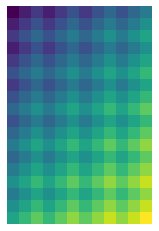

In [137]:
plt.imshow(hankelized_matrix_original)
plt.axis('off');
plt.savefig('hankel_block_matrix.pdf')

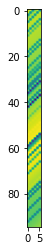

In [368]:
# plt.figure(figsize=(100, 5))
plt.imshow(hankel_matrix)

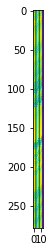

In [369]:
plt.imshow(H_e)

In [80]:
# reshape to 5th order tensor
I1, I2 = H.shape
D1 = int(I1/P - T1 +1)
D2 = int(I2/P - T2 +1)
tensor = H_e.reshape(P, P, T1, D1, T2, D2)
mask_tensor = mask_e.reshape(P, P, T1, D1, T2, D2)

In [81]:
tensor_index = hankelized_matrix.reshape(P, P, T1, D1, T2, D2)
tensor_original = hankelized_matrix_original.reshape(P, P, T1, D1, T2, D2)

In [82]:
# create a tensor of indices (for dehankelization) and an approximation tensor
H_ = np.multiply(mask_tensor, tensor) + np.multiply((np.ones(mask_tensor.shape) - mask_tensor), np.zeros(tensor.shape))
ind = np.zeros((np.prod(tensor.shape), 6))
values = np.zeros(np.prod(tensor.shape))
index = 0
for i in range(tensor.shape[0]):
    for j in range(tensor.shape[1]):
        for k in range(tensor.shape[2]):
            for l in range(tensor.shape[3]):
                for m in range(tensor.shape[4]):
                    for x in range(tensor.shape[5]):
                        ind[index, :] = [i, j, k, l, m, x]
                        values[index] = H_[i, j, k, l, m, x]
#                         values[index] = tensor[i, j, k, l, m, x]
                        index += 1
ind = ind.astype(int)

In [83]:
cooP = {'values': values, 'indices': ind}

In [106]:
def result_approx(tensor, mask_tensor, cooP, initial_cores, num_steps=100, eps=1e-3):
    """Returns the approximated tensor X1 and some error values in f "
    Input:
    tensor: original tensor 
    mask_tesnor: mask tensor
    cooP: dict of values of the original tensor
    initial_cores: initial core values
    num_steps: number of steps
    eps: tolerance
    """
    #first step
    errors = []
    errors_als = []
    count = 0
    shape = np.array(tensor.shape)
    X1, f, cores = ttSparseALS(
                    cooP,
                    shape,
                    x0=tt.vector.from_list(initial_cores),
                    ttRank=5,
                    maxnsweeps=50,
                    verbose=True,
                    tol=1e-8,
                    alpha = 1e-2
    ) # the 1st approxamation with tt)als
    errors_als.append(f['fit'])
    
    while count < num_steps and np.linalg.norm(np.multiply(mask_tensor, tensor_original - X1.full()) ) > eps:
        fl = False
        count = count + 1
        print('Num steps', count)
        err = error_func(tensor, mask_tensor, X1.full(), tt.vector.to_list(X1)) # calculate omisiion errors
        idx = np.argsort(err)[::-1] # the highest error
#         print('Change idx', idx[0], idx)
        
        for i in range(len(idx)):
            increased_cores, fl = increase_ranks(idx[i], tt.vector.to_list(X1)) # increase ranks of the cores
            if fl == False:
#                 print('Not increased rank', idx[i])
                continue
            else: 
#                 print('Increased rank', idx[i])
#                 print(increased_cores[idx[i]].shape)
                break
        # update values
        H_ = np.multiply(mask_tensor, tensor) + np.multiply((np.ones(mask_tensor.shape) - mask_tensor), X1.full())
        ind = np.zeros((np.prod(tensor.shape), 6))
        values = np.zeros(np.prod(tensor.shape))
        index = 0
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                for k in range(tensor.shape[2]):
                    for l in range(tensor.shape[3]):
                        for m in range(tensor.shape[4]):
                            for x in range(tensor.shape[5]):
                                ind[index, :] = [i, j, k, l, m, x]
                                values[index] = H_[i, j, k, l, m, x]
        #                         values[index] = tensor[i, j, k, l, m, x]
                                index += 1
        ind = ind.astype(int)
        cooP = {'values': values, 'indices': ind}
        # tt_als again
        X1, f, cores = ttSparseALS(
                    cooP,
                    shape,
                    x0=tt.vector.from_list(increased_cores),
                    ttRank=5,
                    maxnsweeps=50,
                    verbose=True,
                    tol=1e-8,
                    alpha = 1e-3)
        errors_als.append(f['fit'])
        errors.append(np.linalg.norm(np.multiply(mask_tensor, tensor_original - X1.full()) ))
        print('Error:', errors[-1])
        
    
    print('Total iters:', count)
    
    return X1, f

In [107]:
def error_func(tensor, mask_tensor, recovered_tensor, cores):
    """returns the omission errors of every core
    tensor: original tensor
    mask_tensor: mask tensor
    recovered_tensor: approximated tensor
    cores: list of cores
    """
    errors = []
    n = 6
    
    for i in range(n):
        G_2_inv = np.linalg.pinv(cores[i].reshape(cores[i].shape[1], -1))
        e = G_2_inv @ (np.multiply(mask_tensor.reshape(mask_tensor.shape[i], -1), tensor.reshape(tensor.shape[i], -1) - recovered_tensor.reshape(recovered_tensor.shape[i], -1)))
        e = np.linalg.norm(e)
        errors.append(e)
    return errors 

In [108]:
def increase_ranks(ind, cores_):
    """increases the ranks of selected cores 
    ind: an index of the core which ranks should be increased
    cores_: list of cores
    """
    fl = False
#     i = ind
    cores = cores_.copy()
    if ind == 0: 
        r = 1 + cores[0].shape[2]
#         print(r, cores[0].shape[0] * cores[0].shape[1], cores[1].shape[1] * cores[1].shape[2])
        if min(r, cores[0].shape[0] * cores[0].shape[1], cores[1].shape[1] * cores[1].shape[2]) == r:
            print('we are here 0')
            fl = True
            a = np.zeros((cores[0].shape[0], cores[0].shape[1], 1))
            cores[0] = np.concatenate((cores[0], a), axis=2)

            a = np.zeros((1, cores[1].shape[1], cores[1].shape[2]))
            cores[1] = np.concatenate((cores[1], a), axis=0)
    elif ind == 5: 
        r = 1 + cores[5].shape[0]
        if min(r, cores[5].shape[1] * cores[5].shape[2], cores[4].shape[0] * cores[4].shape[0]) == r:
            print('we are here 5')
            fl = True
            a = np.zeros((1, cores[5].shape[1], cores[5].shape[2]))
            cores[5] = np.concatenate((cores[5], a), axis=0)

            a = np.zeros((cores[4].shape[0], cores[4].shape[1], 1))
            cores[4] = np.concatenate((cores[4], a), axis=2)
        
    else: 
#         print('hello')
        i = ind
#         print(cores[i].shape)
        # increase central 1st-rank
        r = 1 + cores[i].shape[0]
        if min(r, cores[i].shape[1] * cores[i].shape[2], cores[i-1].shape[0]* cores[i-1].shape[1]) == r:
            print('we are here middle', i)
            fl = True
            a = np.zeros((1, cores[i].shape[1], cores[i].shape[2]))
            cores[i] = np.concatenate((cores[i], a), axis=0)
            a = np.zeros((cores[i-1].shape[0], cores[i-1].shape[1], 1))
            cores[i-1] = np.concatenate((cores[i-1], a), axis=2)
#         increase central 3rd-rank
        r = 1 + cores[i].shape[2]
        if min(r, cores[i].shape[0] * cores[i].shape[1], cores[i+1].shape[1] * cores[i+1].shape[2]) == r:
            fl = True
            print('we are here middle', i)
            b = np.zeros((cores[i].shape[0], cores[i].shape[1], 1))
            cores[i] = np.concatenate((cores[i], b), axis=2)
            a = np.zeros((1, cores[i+1].shape[1], cores[i+1].shape[2]))
            cores[i+1] = np.concatenate((cores[i+1], a), axis=0)
         
    return cores, fl

In [109]:
import time

In [111]:
test_cores = [np.random.randn(1, 2, 1), np.random.randn(1, 2, 1), np.random.randn(1, 4, 1), np.random.randn(1, 900, 1), np.random.randn(1, 2, 1), np.random.randn(1, 99, 1)]
# H_ = np.multiply(mask_tensor, tensor) + np.multiply((np.ones(mask_tensor.shape) - mask_tensor), tt.vector.from_list(test_cores).full())
H_ = tensor.copy()
ind = np.zeros((np.prod(tensor.shape), 6))
values = np.zeros(np.prod(tensor.shape))
index = 0
for i in range(tensor.shape[0]):
    for j in range(tensor.shape[1]):
        for k in range(tensor.shape[2]):
            for l in range(tensor.shape[3]):
                for m in range(tensor.shape[4]):
                    for x in range(tensor.shape[5]):
                        ind[index, :] = [i, j, k, l, m, x]
                        values[index] = H_[i, j, k, l, m, x]
#                         values[index] = tensor[i, j, k, l, m, x]
                        index += 1
ind = ind.astype(int)
cooP = {'values': values, 'indices': ind}
# test_approx = tt.vector.from_list(test_cores)
# test_cores = np.array([np.ones((1, 1, 1)), np.ones((1, 1, 1)), np.ones((1, 3, 2)), np.ones((2, 93, 2)), np.ones((2, 4, 2)), np.ones((2, 3, 1))])
X_approx, f = result_approx(tensor, mask_tensor, cooP, test_cores, num_steps=100, eps=1e-3)

/Library/Python/3.7/site-packages/ipykernel_launcher.py:194: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Library/Python/3.7/site-packages/ipykernel_launcher.py:208: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Library/Python/3.7/site-packages/ipykernel_launcher.py:210: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/Library/Python/3.7/site-packages/ipykernel_launcher.py:220: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Initialization time: 0.000 seconds (proc.time)


/Library/Python/3.7/site-packages/ipykernel_launcher.py:277: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


sweep 1/50	 fit value: 4.78781e-01	 time: 1.083 seconds (proc.time)
Total sweep time: 4.001 seconds (proc.time)	 Total time: 4.001 seconds (proc.time)
Num steps 1
we are here middle 2
Initialization time: 0.000 seconds (proc.time)
sweep 1/50	 fit value: 2.72026e-03	 time: 1.088 seconds (proc.time)
Total sweep time: 1.088 seconds (proc.time)	 Total time: 1.088 seconds (proc.time)
Num steps 2
we are here middle 4
we are here middle 4
Initialization time: 0.000 seconds (proc.time)
sweep 1/50	 fit value: 4.32151e-04	 time: 1.121 seconds (proc.time)
Total sweep time: 1.121 seconds (proc.time)	 Total time: 1.122 seconds (proc.time)
Num steps 3
we are here 5
Initialization time: 0.000 seconds (proc.time)
sweep 1/50	 fit value: 3.25394e-04	 time: 1.022 seconds (proc.time)
Total sweep time: 1.022 seconds (proc.time)	 Total time: 1.022 seconds (proc.time)
Num steps 4
we are here middle 3
Initialization time: 0.000 seconds (proc.time)
sweep 1/50	 fit value: 3.18667e-04	 time: 1.070 seconds (proc.

sweep 1/50	 fit value: 3.18013e-04	 time: 1.250 seconds (proc.time)
Total sweep time: 1.250 seconds (proc.time)	 Total time: 1.250 seconds (proc.time)
Num steps 39
Initialization time: 0.000 seconds (proc.time)
sweep 1/50	 fit value: 3.18013e-04	 time: 1.197 seconds (proc.time)
Total sweep time: 1.197 seconds (proc.time)	 Total time: 1.198 seconds (proc.time)
Num steps 40
Initialization time: 0.000 seconds (proc.time)
sweep 1/50	 fit value: 3.18013e-04	 time: 1.210 seconds (proc.time)
Total sweep time: 1.210 seconds (proc.time)	 Total time: 1.210 seconds (proc.time)
Num steps 41
Initialization time: 0.000 seconds (proc.time)
sweep 1/50	 fit value: 3.18013e-04	 time: 1.222 seconds (proc.time)
Total sweep time: 1.222 seconds (proc.time)	 Total time: 1.223 seconds (proc.time)
Num steps 42
Initialization time: 0.000 seconds (proc.time)
sweep 1/50	 fit value: 3.18013e-04	 time: 1.215 seconds (proc.time)
Total sweep time: 1.215 seconds (proc.time)	 Total time: 1.215 seconds (proc.time)
Num s

sweep 1/50	 fit value: 3.18013e-04	 time: 1.313 seconds (proc.time)
Total sweep time: 1.313 seconds (proc.time)	 Total time: 1.313 seconds (proc.time)
Num steps 78
Initialization time: 0.000 seconds (proc.time)
sweep 1/50	 fit value: 3.18013e-04	 time: 1.317 seconds (proc.time)
Total sweep time: 1.317 seconds (proc.time)	 Total time: 1.317 seconds (proc.time)
Num steps 79
Initialization time: 0.000 seconds (proc.time)
sweep 1/50	 fit value: 3.18013e-04	 time: 1.310 seconds (proc.time)
Total sweep time: 1.310 seconds (proc.time)	 Total time: 1.311 seconds (proc.time)
Num steps 80
Initialization time: 0.000 seconds (proc.time)
sweep 1/50	 fit value: 3.18013e-04	 time: 1.207 seconds (proc.time)
Total sweep time: 1.207 seconds (proc.time)	 Total time: 1.207 seconds (proc.time)
Num steps 81
Initialization time: 0.000 seconds (proc.time)
sweep 1/50	 fit value: 3.18013e-04	 time: 1.219 seconds (proc.time)
Total sweep time: 1.219 seconds (proc.time)	 Total time: 1.219 seconds (proc.time)
Num s

In [112]:
np.linalg.norm(np.multiply(X_approx.full(), mask_tensor) - np.multiply(tensor, mask_tensor)) / np.linalg.norm(np.multiply(tensor, mask_tensor))

0.027332367804104096

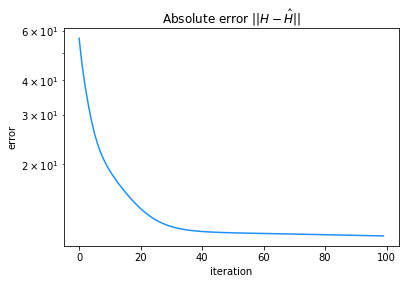

In [390]:
plt.plot(errors, color='dodgerblue')
plt.title(r'Absolute error $||H-\hat{H}||$')
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('error');
plt.savefig('error_2_step.pdf')

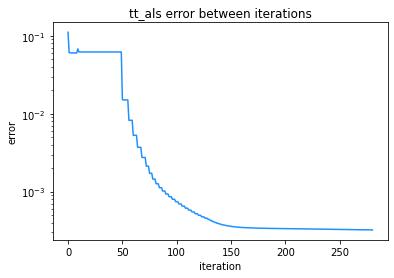

In [391]:
plt.plot(np.concatenate(np.array(errors_als), axis=0), color='dodgerblue')
plt.title('tt_als error between iterations')
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('error');
plt.savefig('error_als_2nd_step.pdf')

In [378]:
als_tensor = X_approx.full()

In [382]:
# dehankelization procedure
restored_array_sums = np.zeros(L)
restored_array_counts = np.zeros(L)

for i in range(als_tensor.shape[0]):
    for j in range(als_tensor.shape[1]):
        for k in range(als_tensor.shape[2]):
            for l in range(als_tensor.shape[3]):
                for m in range(als_tensor.shape[4]):
                    for n in range(als_tensor.shape[5]):
                        restored_array_sums[int(tensor_index[i, j, k, l, m, n])] += als_tensor[i, j, k, l, m, n]
                        restored_array_counts[int(tensor_index[i, j, k, l, m, n])] += 1

res_data = restored_array_sums / restored_array_counts

/Library/Python/3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [350]:
res_data[-1] = res_data[-2]

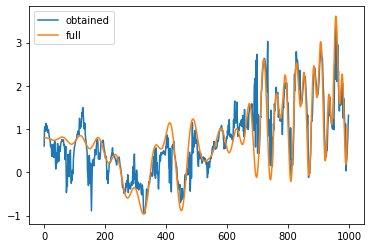

In [1838]:
plt.plot(res_data, label='obtained')
plt.plot(val_original, label='full')
# plt.plot(np.multiply(val[2:-3], mask[2:-3]), label='with missing values')
plt.legend()

In [1840]:
res_data[-1] = res_data[-2]

In [385]:
# smoothing of results
smooth_res = []
for i in range(2, len(res_data)-3):
    if mask[i] == 1:
        smooth_res.append(res_data[i])
    else:
        smooth_res.append((res_data[i-2] + res_data[i-1] + res_data[i] + res_data[i+2] + res_data[i+3]) / 5)

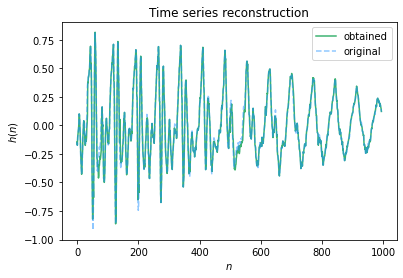

In [109]:
plt.plot(smooth_res, color='mediumseagreen', label='obtained')
plt.plot(val_original[2:-3], '--', color='dodgerblue', label='original', alpha=0.5)
plt.title('Time series reconstruction')
plt.ylabel('$h(n)$')
plt.xlabel('$n$')
# plt.plot(np.multiply(val[2:-3], mask[2:-3]), label='with missing values')
plt.legend()
# plt.xlim(0,1000)
plt.savefig('res_reconstruct_speech.pdf')

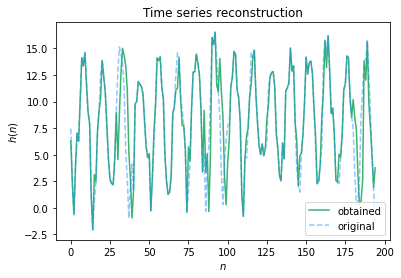

In [220]:
# plt.figure(figsize=(10, 6))
plt.plot(smooth_res, color='mediumseagreen', label='obtained')
plt.plot(val_original[2:-3], '--', color='dodgerblue', label='original', alpha=0.5)
plt.title('Time series reconstruction')
plt.ylabel('$h(n)$')
plt.xlabel('$n$')
plt.legend()
# plt.xlim(0,1000)
# plt.savefig('res_reconstruct_tempreture.pdf')

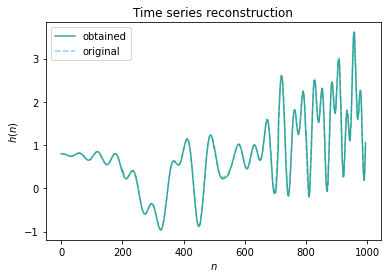

In [161]:
# plt.figure(figsize=(10, 6))
plt.plot(smooth_res, color='mediumseagreen', label='obtained')
plt.plot(val_original[2:-3], '--', color='dodgerblue', label='original', alpha=0.5)
plt.title('Time series reconstruction')
plt.ylabel('$h(n)$')
plt.xlabel('$n$')
# plt.plot(np.multiply(val[2:-3], mask[2:-3]), label='with missing values')
plt.legend()
# plt.xlim(0,1000)
# plt.savefig('res_reconstruct_1000val.pdf')